# LANL Earthquake Prediction

## Get Data:

To get the data, we only have to download it from the database and open it, altough there was to much data, thus, I splitted the data into 4196 csv files of 150000 rows each

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


# define constants
DATA_DIR = "data/"
TRAIN_DIR = "data/train/"
MODELS_DIR = "models/"
TEST_DIR = os.path.join(DATA_DIR, "test/")


# load data into dataframe
train_files = os.listdir(TRAIN_DIR);
train_files.sort()
LANL_train_set = pd.read_csv(os.path.join(TRAIN_DIR, train_files[42]))
LANL_train_array = np.array(LANL_train_set['acoustic_data'])
LANL_train_labels = np.array(LANL_train_set['time_to_failure'])
LANL_mean = np.mean(LANL_train_array)
LANL_std  = np.std(LANL_train_array)
LANL_variance = np.var(LANL_train_array)

## Analize Data:

First of all, lets plot the head of the data into our notebook, tyo see an example of what we are working with

In [2]:
LANL_train_set.head()

,acoustic_data,time_to_failure
0,8,11.3737
1,8,11.3737
2,3,11.3737
3,3,11.3737
4,1,11.3737


Now, let's plot all the acoustic data to have a more visual representation of it. For this, I made a function that generates different plots we can use such as an histogram and a boxplot

In [3]:
def gen_plots(x):
    n_bins = 70
    rows = 3
    cols = 1
    plt.figure(1, figsize=(7, 15))
    # plot data
    plt.subplot(rows, cols, 1)
    plt.plot(x)
    
    # plot histogram
    hist = plt.subplot(rows, cols, 2)
    hist.set_title("Histogram")
    n, bins, patches = plt.hist(x, n_bins, facecolor='orange', alpha=0.5)
    
    # plot boxplot
    boxplot = plt.subplot(rows, cols, 3)
    plt.boxplot(x)
    boxplot.set_title("Boxplot")
    plt.show()


Next we generate the different plots, we can see form the histogram that the instance follows a normal distribution and the most of the values are positive, this may vary from instance to instace, altought all of them a similar distribition. 

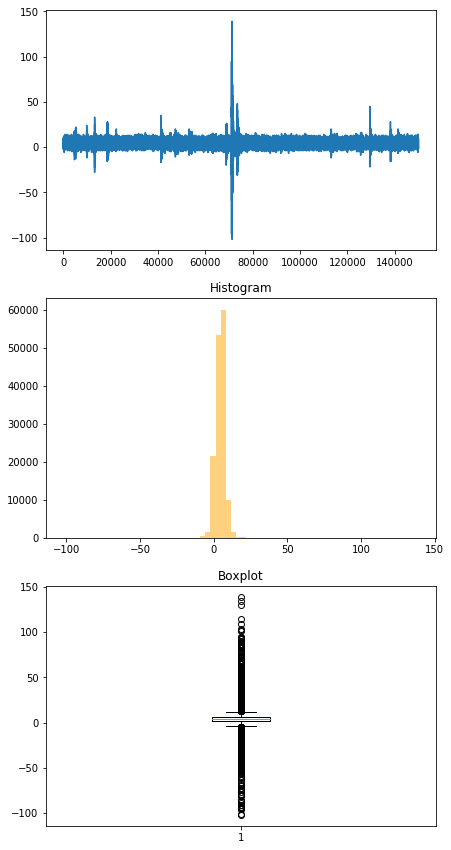

In [4]:
gen_plots(LANL_train_array)

The data we are using right represents only a single intance wich is a time segment with only one label. With this instance we might neeed to do some feature engeneering. Let's see some example of qualities we can get from the instance and its label. From this data, I concluded that we can use the mean of all the failure times from the instance as the single label for the instance.

In [5]:
print("Mean: ", LANL_mean)
print("Standard deviation: ", LANL_std)
print("Variance: ", LANL_variance)
print("Time to failure mean: ", np.mean(LANL_train_labels))
print("Max time to failure: ", np.max(LANL_train_labels))
print("Min time to failure: ", np.min(LANL_train_labels))

Mean:  4.3839733333333335
Standard deviation:  4.22277844702066
Variance:  17.83185781262222
Time to failure mean:  11.354673242272735
Max time to failure:  11.373699597
Min time to failure:  11.335396800000002


We can see we are starting to make new features for this instance, let's save it in a pandas dataframe 

In [6]:
features = np.array([LANL_mean, LANL_std, LANL_variance])
LANL_train = pd.DataFrame({'mean' : [features[0]], 'deviation' : [features[1]], 'variance' : features[2]})

In [7]:
LANL_train

,mean,deviation,variance
0,4.383973,4.222778,17.831858


Now we have a nice way to store all the features for each instance. But it seems a bit deorganized and once we start adding functions and features it will get more complicated; so let's make a simple pipeline to automatize all the process. For this I created a list of functions to make each feature and an estimator that applies each function to the instance. 

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import skew, kurtosis

cv =  lambda x: np.std(x) / np.mean(x)


# feature functions
feature_names = ['mean', 'deviation', 'variance', 
                 'min', 'max', 'skewness',
                 'kurtosis', 'quantile_25', 'quantile_50',
                 'quantile_75', 'q95', 'q99', 'q05', 'q01', 'abs_q95', 
                 'abs_q99', 'abs_q05', 'abs_q01', 'coeficient__of_variation',
                 'std_first_50000', 'std_last_50000', 'std_first_10000', 'std_last_10000',
                 'avg_first_50000', 'avg_last_50000', 'avg_first_10000', 'avg_last_10000',
                 'min_first_50000', 'min_last_50000', 'min_first_10000', 'min_last_10000',
                 'max_first_50000', 'max_last_50000', 'max_first_10000', 'max_last_10000']
for window in ['10', '100', '1000']:
    feature_names.append('ave_roll_std_' + window)
    feature_names.append('std_roll_std_' + window)
    feature_names.append('max_roll_std_' + window)
    feature_names.append('min_roll_std_' + window)
    feature_names.append('q01_roll_std_' + window)
    feature_names.append('q05_roll_std_' + window)
    feature_names.append('q95_roll_std_' + window)
    feature_names.append('q99_roll_std_' + window)
    feature_names.append('av_change_abs_roll_std_' + window)
    feature_names.append('av_change_rate_roll_std_' + window)
    feature_names.append('abs_max_roll_std_' + window)
    feature_names.append('ave_roll_mean_' + window)
    feature_names.append('std_roll_mean_' + window)
    feature_names.append('max_roll_mean_' + window)
    feature_names.append('min_roll_mean_' + window)
    feature_names.append('q01_roll_mean_' + window)
    feature_names.append('q05_roll_mean_' + window)
    feature_names.append('q95_roll_mean_' + window)
    feature_names.append('q99_roll_mean_' + window)
    feature_names.append('av_change_abs_roll_mean_' + window)
    feature_names.append('av_change_rate_roll_mean_' + window)
    feature_names.append('abs_max_roll_mean_' + window)
    
feature_trans = {'mean' : np.mean, 'deviation' : np.std, 'variance' : np.var, 
                 'min' : np.min, 'max' : np.max, 'skewness' : skew,
                 'kurtosis' : kurtosis, 'quantile' : np.quantile, 'coeficient__of_variation' : cv}

class FeatureGenerator(BaseEstimator, TransformerMixin):
   
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        features = []
        for name in feature_trans:
            if name == 'quantile':
                features.append(feature_trans[name](X, .25))
                features.append(feature_trans[name](X, .50))
                features.append(feature_trans[name](X, .75))
                features.append(feature_trans[name](X, 0.95))
                features.append(feature_trans[name](X, 0.99))
                features.append(feature_trans[name](X, 0.05))
                features.append(feature_trans[name](X, 0.01))
                features.append(feature_trans[name](np.abs(X), 0.95))
                features.append(feature_trans[name](np.abs(X), 0.99))
                features.append(feature_trans[name](np.abs(X), 0.05))
                features.append(feature_trans[name](np.abs(X), 0.01))
            else:
                features.append(feature_trans[name](X))
        features.append(np.mean(X[:50000]))
        features.append(np.mean(X[50000:]))
        features.append(np.mean(X[:10000]))
        features.append(np.mean(X[10000:]))
        features.append(np.std(X[:50000]))
        features.append(np.std(X[50000:]))
        features.append(np.std(X[:10000]))
        features.append(np.std(X[10000:]))
        features.append(np.min(X[:50000]))
        features.append(np.min(X[50000:]))
        features.append(np.min(X[:10000]))
        features.append(np.min(X[10000:]))
        features.append(np.max(X[:50000]))
        features.append(np.max(X[50000:]))
        features.append(np.max(X[:10000]))
        features.append(np.max(X[10000:]))
        X = pd.Series(X)
        for windows in [10, 100, 1000]:
            x_roll_std = X.rolling(windows).std().dropna().values
            x_roll_mean = X.rolling(windows).mean().dropna().values
            features.append(x_roll_std.mean())
            features.append(x_roll_std.std())
            features.append(x_roll_std.max())
            features.append(x_roll_std.min())
            features.append(np.quantile(x_roll_std, 0.01))
            features.append(np.quantile(x_roll_std, 0.05))
            features.append(np.quantile(x_roll_std, 0.95))
            features.append(np.quantile(x_roll_std, 0.99))
            features.append(np.mean(np.diff(x_roll_std)))
            features.append(np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0]))
            features.append(np.abs(x_roll_std).max())
            features.append(x_roll_mean.mean())
            features.append(x_roll_mean.std())
            features.append(x_roll_mean.max())
            features.append(x_roll_mean.min())
            features.append(np.quantile(x_roll_mean, 0.01))
            features.append(np.quantile(x_roll_mean, 0.05))
            features.append(np.quantile(x_roll_mean, 0.95))
            features.append(np.quantile(x_roll_mean, 0.99))
            features.append(np.mean(np.diff(x_roll_mean)))
            features.append(np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0]))
            features.append(np.abs(x_roll_mean).max())
        return np.c_[features]

Now let's generate the features for all the instances in the dataset. The following function automates all the process from getting the data, appaying the function and finally normalazing it. 

In [9]:
from sklearn.preprocessing import StandardScaler

def GetTrainInstances(max_inst=-1, directory=TRAIN_DIR, normalize=True, log=False):
    LANL_X = []
    LANL_y = []
    i = 0

    gen = FeatureGenerator()
    scaler = StandardScaler()
    max_instances = max_inst
    print("Progress:")
    for file in train_files:
        if i == max_instances:
            break
        if i % 42 == 0:
            print(int(i / 42), end='.')
        tmp = pd.read_csv(os.path.join(directory, file))
        tmp_data = np.array(tmp['acoustic_data'])
        tmp_labels = np.array(tmp['time_to_failure'])
        if log:
            for element in tmp_data:
                if element < 0:
                    element = -np.log10(abs(element))
                elif element > 0:
                    element = np.log10(element)
        LANL_X.append(gen.fit_transform(tmp_data))
        # for all time instances we get the mean
        LANL_y.append(np.mean(tmp_labels)) 
        i += 1
    if normalize:
        LANL_X = scaler.fit_transform(np.array(LANL_X).reshape(max_instances, len(feature_names)))
    LANL_X = pd.DataFrame(np.array(LANL_X).reshape(max_instances, len(feature_names)), columns=feature_names)
    LANL_y = pd.DataFrame(np.array(LANL_y).reshape(max_instances, 1), columns=['time_to_failure'])
    LANL_X.to_csv(os.path.join(DATA_DIR, "train_data.csv"), sep=',', encoding='utf-8', index=False)
    LANL_y.to_csv(os.path.join(DATA_DIR, "train_labels.csv"), sep=',', encoding='utf-8', index=False)
    return LANL_X, LANL_y
            
    

In [69]:
LANL_X, LANL_y = GetTrainInstances(max_inst=-1, normalize=True, log=False)

Progress:
0.

/home/polmonroig/miniconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: divide by zero encountered in true_divide
/home/polmonroig/miniconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide


1.

/home/polmonroig/miniconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning: divide by zero encountered in true_divide


2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.

We could also load the dataset that has been generated. 

In [10]:
LANL_X = pd.read_csv(os.path.join(DATA_DIR, "train_data.csv"))
LANL_y = pd.read_csv(os.path.join(DATA_DIR, "train_labels.csv"))

For now I only loaded 200 instances of the dataset because it is easier to work with. When we start training the model I will include all the dataset

In [11]:
LANL_X.head()

,mean,deviation,variance,min,max,skewness,kurtosis,quantile_25,quantile_50,quantile_75,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,1.424140,-0.170214,-0.080583,0.193218,-0.218194,-0.313703,-0.491310,1.594316,0.947037,0.288822,...,0.268470,-0.004742,0.178278,0.287332,0.965402,1.509153,0.885262,-0.631300,-1.832422,-0.004742
1,0.805716,0.004734,-0.064868,-0.018037,0.063936,0.553891,0.431696,-0.405852,0.947037,0.288822,...,-0.141264,0.007341,-0.025387,0.622391,0.842747,0.522428,0.294357,-0.912054,-0.890022,0.007341
2,1.511155,0.049252,-0.060230,0.163039,-0.086289,0.191534,-0.492831,-0.405852,0.947037,0.288822,...,0.085078,0.099556,0.245184,0.634878,1.207106,1.530919,0.889790,0.441128,0.639209,0.099556
3,1.494934,0.043950,-0.060796,-0.187796,0.122560,1.321245,0.683938,-0.405852,0.947037,0.288822,...,0.083085,0.068076,0.105059,0.770151,1.160208,1.432972,0.815078,-0.949994,-1.097513,0.068076
4,1.520242,0.088495,-0.055927,0.087590,-0.067969,-0.128324,-0.217434,-0.405852,0.947037,0.288822,...,-0.164151,0.138032,0.187535,1.040695,1.557034,1.393068,0.901110,0.595416,-0.465464,0.138032


Now let's try to find out more information about the dataset looking at the correlation of the features

In [76]:
LANL_X.corr()

,mean,deviation,variance,min,max,skewness,kurtosis,quantile_25,quantile_50,quantile_75,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
mean,1.000000,0.010820,0.010008,-0.006316,0.013494,-0.002517,-0.001545,0.511647,0.794163,0.522219,...,0.014316,0.091174,0.100297,0.515521,0.916734,0.933774,0.597466,0.003627,0.006118,0.091174
deviation,0.010820,1.000000,0.956127,-0.963867,0.964585,0.055543,0.333802,-0.382487,-0.006846,0.408645,...,0.907130,0.949747,-0.954084,-0.758859,-0.268339,0.239889,0.720341,-0.083912,0.204097,0.949747
variance,0.010008,0.956127,1.000000,-0.904037,0.895722,0.029222,0.183733,-0.286210,-0.000429,0.318630,...,0.939392,0.951774,-0.955905,-0.794548,-0.277607,0.245352,0.740951,-0.090695,0.196283,0.951774
min,-0.006316,-0.963867,-0.904037,1.000000,-0.958889,-0.006328,-0.463737,0.346719,0.009994,-0.371779,...,-0.873725,-0.933443,0.937743,0.724281,0.257732,-0.226616,-0.666382,0.078587,-0.186458,-0.933443
max,0.013494,0.964585,0.895722,-0.958889,1.000000,0.140661,0.463951,-0.337078,-0.003218,0.366588,...,0.842807,0.904893,-0.910499,-0.705854,-0.239647,0.215590,0.665360,-0.089456,0.212299,0.904893
skewness,-0.002517,0.055543,0.029222,-0.006328,0.140661,1.000000,0.144331,-0.021153,0.009313,0.009858,...,0.018926,0.030619,-0.035462,-0.020706,-0.011176,0.001959,0.027146,-0.015912,0.045968,0.030619
kurtosis,-0.001545,0.333802,0.183733,-0.463737,0.463951,0.144331,1.000000,-0.125803,-0.015036,0.132285,...,0.172808,0.270811,-0.277989,-0.132016,-0.045031,0.034692,0.123722,-0.007556,0.089129,0.270811
quantile_25,0.511647,-0.382487,-0.286210,0.346719,-0.337078,-0.021153,-0.125803,1.000000,0.435939,-0.082020,...,-0.298628,-0.267281,0.360986,0.524919,0.583910,0.376721,0.054310,-0.001396,-0.012304,-0.267281
quantile_50,0.794163,-0.006846,-0.000429,0.009994,-0.003218,0.009313,-0.015036,0.435939,1.000000,0.409245,...,0.007862,0.063367,0.088538,0.410808,0.727135,0.740455,0.467624,0.000019,-0.009477,0.063367
quantile_75,0.522219,0.408645,0.318630,-0.371779,0.366588,0.009858,0.132285,-0.082020,0.409245,1.000000,...,0.332238,0.380289,-0.281267,-0.009354,0.356877,0.592698,0.573243,-0.010166,0.021173,0.380289


With what we have now let's divide the data into training set and testing set

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.array(LANL_X), np.array(LANL_y), test_size=0.2, random_state=42)

In [13]:
y_train.shape

(3355, 1)

Before going any further I want to make a function that makes predictions and saves them for upload to kaggle

In [15]:
def MakeSubmission(model):
    col_names = ['seg_id', 'time_to_failure']
    sub  = pd.DataFrame(columns = col_names)
    gen = FeatureGenerator()
    scaler = StandardScaler()
    for i, file in enumerate(os.listdir(TEST_DIR)):
        tmp = pd.read_csv(os.path.join(TEST_DIR, file))
        tmp_data = np.array(tmp['acoustic_data'])
        d = gen.fit_transform(tmp_data)
        scaler.fit_transform(d)
        pred = model.predict(d.reshape(1, -1))
        sub.loc[i] = [file[:-4], pred[0]]
        
    sub.to_csv("submission.csv", sep=',', encoding='utf-8', index=False)
        

Wwe also need a method to validate how good our model is 

In [14]:
from sklearn.model_selection import cross_val_score

def display_scores(model, X, y):
    scores = cross_val_score(model, X, y, 
                             scoring="neg_mean_absolute_error", cv=10)
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

## Training

Now let's see how well a model performs. I uses a random forest because I like them and not for anything in particular, altough later we will need to test a lot of models and select a few promising

### Random Forest

In [81]:
from sklearn.ensemble import RandomForestRegressor

model_rfr = RandomForestRegressor(n_estimators=1000, criterion="mae", 
                                    random_state=42, n_jobs=-1)

In [82]:
model_rfr.fit(X_train, y_train.reshape(-1))

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Before going any further let's save our model

In [86]:
from sklearn.externals import joblib

joblib.dump(model_rfr, os.path.join(MODELS_DIR, "model_rfr.pkl"))

['models/model_rfr.pkl']

Instead of fitting and creating our model let's load it 

In [16]:
from sklearn.externals import joblib

model_rfr = joblib.load(os.path.join(MODELS_DIR, "model_rfr.pkl"))

Now that we have trained the random forest regressor, let's find out the feature importances. As we can see the deviation is the feature that has the most importance, altought it does not have to much importance only 20% 

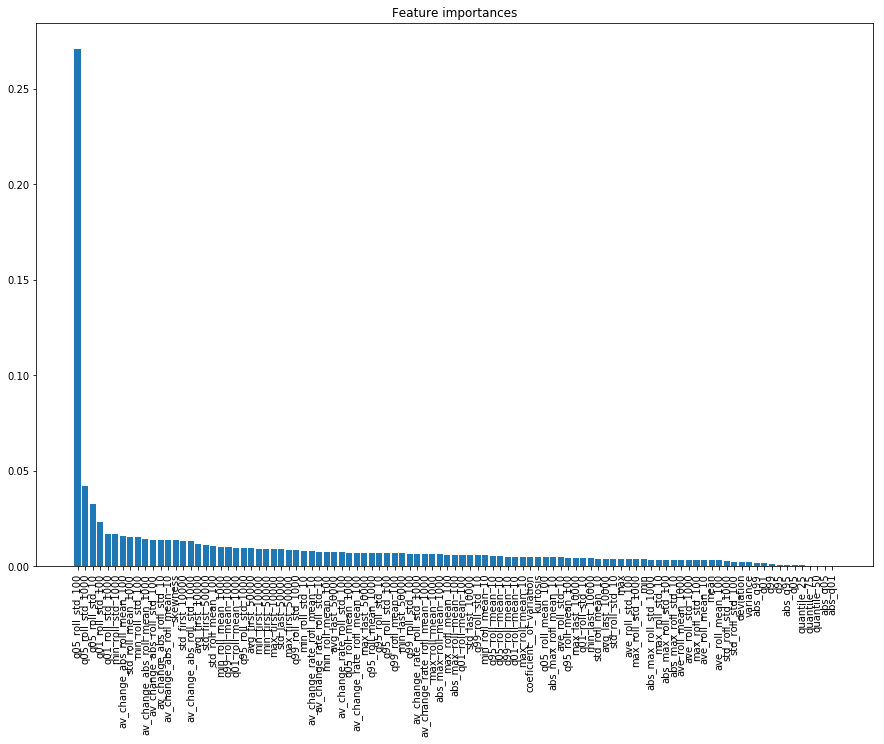

In [17]:
# calculate feature importances
importances = model_rfr.feature_importances_

# sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# rearrange feature names so that they match the sorted feature importances
names = [feature_names[i] for i in indices]

# create plot
plt.figure(figsize=(15,10))
plt.title("Feature importances")

# add bars
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=90)

# show plot
plt.show()

Let's make a simple prediction of our selected testing test

In [84]:
display_scores(model_rfr, X_test, y_test.reshape(-1))

Scores: [-2.20148091 -2.51020124 -2.36524739 -2.49557079 -2.15950182 -1.87327761
 -1.7700168  -1.66759415 -2.53784463 -2.16206244]
Mean: -2.1742797777273717
Standard deviation: 0.29943078083637636


 Mean absolute error: 2.1865890105510672

### Linear Regression

In [79]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [80]:
display_scores(model_lr, X_test, y_test.reshape(-1))

Scores: [-2.68617901 -2.64083079 -2.51504773 -2.52269725 -2.74340903 -2.43951821
 -2.34631373 -2.1953896  -4.20914161 -2.3163774 ]
Mean: -2.661490435006432
Standard deviation: 0.5411692156702017


### Stochastic Gradient Descent

In [45]:
from sklearn.linear_model import SGDRegressor

model_sgd = SGDRegressor(max_iter=50, tol=-np.infty, penalty=None, eta0=0.1, random_state=42)

In [47]:
model_sgd.fit(X_train, y_train.reshape(-1))

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=50,
       n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [49]:
display_scores(model_sgd, X_test, y_test.reshape(-1))

Scores: [-1.28295374e+11 -1.16309139e+11 -1.87637484e+11 -2.39937309e+11
 -1.79393570e+11 -2.60018022e+11 -2.34475151e+11 -2.28906148e+11
 -2.61670855e+11 -1.67937866e+11]
Mean: -200458091691.2497
Standard deviation: 49773084923.24586


### Neural Netowork

In [18]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

In [45]:
X_train[:,0].shape

(3355,)

In [99]:
import tensorflow as tf

tf.reset_default_graph()

model_dnn = tf.estimator.DNNRegressor(hidden_units=[300, 100, 10], 
                                      feature_columns=[tf.feature_column.numeric_column(name) for name in feature_names], 
                                      optimizer=lambda: tf.train.AdamOptimizer(
                                      learning_rate=tf.train.exponential_decay(
                                                     learning_rate=0.1,
                                                     global_step=tf.train.get_global_step(),
                                                     decay_steps=10000,
                                                     decay_rate=0.96)))



def train_input_fn(batch_size=50, n_epochs=40):
    x_dict = {name : X_train[:, i] for i, name in enumerate(feature_names)}
    
    return tf.estimator.inputs.numpy_input_fn(
            x=x_dict,
            y=y_train.astype(np.float32),
            batch_size=batch_size,
            num_epochs=n_epochs,
            shuffle=True)

def test_input_fn(batch_size=50):
    x_dict = {name : X_test[:, i] for i, name in enumerate(feature_names)}
    
    return tf.estimator.inputs.numpy_input_fn(
            x=x_dict, y=y_test, shuffle=False)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmphqhi6e4u', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc7ab2278d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [97]:
model_dnn.train(input_fn=train_input_fn())

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpq847xvkc/model.ckpt.
INFO:tensorflow:loss = 2362.9824, step = 0
INFO:tensorflow:global_step/sec: 86.3398
INFO:tensorflow:loss = 1321.6096, step = 100 (1.161 sec)
INFO:tensorflow:global_step/sec: 119.15
INFO:tensorflow:loss = 822.92175, step = 200 (0.838 sec)
INFO:tensorflow:global_step/sec: 115.438
INFO:tensorflow:loss = 773.5361, step = 300 (0.866 sec)
INFO:tensorflow:global_step/sec: 114.61
INFO:tensorflow:loss = 945.9271, step = 400 (0.874 sec)
INFO:tensorflow:global_step/sec: 119.006
INFO:tensorflow:loss = 676.8478, step = 500 (0.840 sec)
INFO:tensorflow:global_step/sec: 113.312
INFO:tensorflow:loss = 660.59705, step = 600 (0.881 sec)
INFO:tensorflow:global_step/sec: 116.005
INFO:tensorflow:loss 

In [100]:

eval_results = model_dnn.evaluate(input_fn=test_input_fn())

INFO:tensorflow:Could not find trained model in model_dir: /tmp/tmphqhi6e4u, running initialization to evaluate.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-17-12:12:54
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-17-12:12:54
INFO:tensorflow:Saving dict for global step 0: average_loss = 42.246635, global_step = 0, label/mean = 5.6758795, loss = 5063.561, prediction/mean = 0.32735428


In [101]:
eval_results

{'average_loss': 42.246635,
 'label/mean': 5.6758795,
 'loss': 5063.561,
 'prediction/mean': 0.32735428,
 'global_step': 0}

In [103]:
y_pred_iter = model_dnn.predict(input_fn=test_input_fn())
y_pred = list(y_pred_iter)



INFO:tensorflow:Could not find trained model in model_dir: /tmp/tmphqhi6e4u, running initialization to predict.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'predictions': array([-0.38102034], dtype=float32)}

In [109]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, [p['predictions'][0] for p in y_pred])

6.0190819071079735